In [156]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

## 1. Data Understanding

In [157]:
data=pd.read_csv("day.csv")
data.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [158]:
#Dropping columns :
#instant-not needed as index is not useful
#dteday - already days,year and month is covered in other features
#casual,registered - since casual and registered cannot predict total count,they are just a biforcation of target variable
data.drop(["instant","dteday","casual","registered"],axis=1,inplace=True)

In [159]:
data.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,1600


## 2. Exploratory Data Analysis

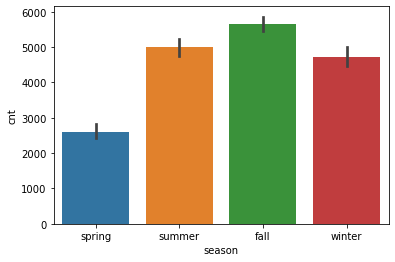

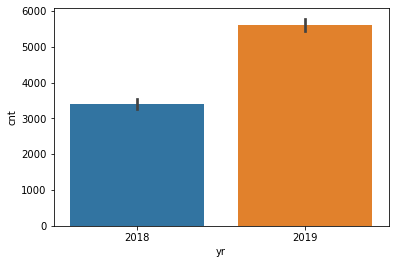

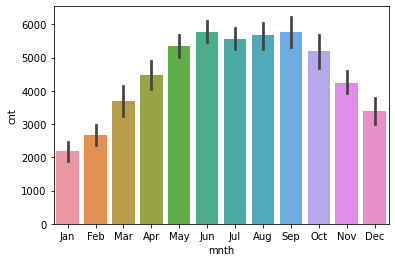

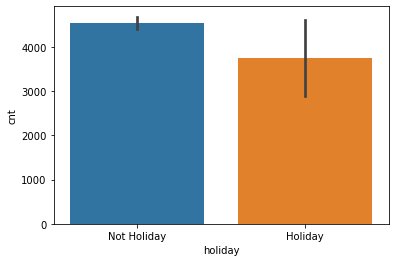

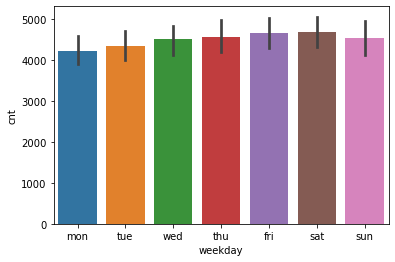

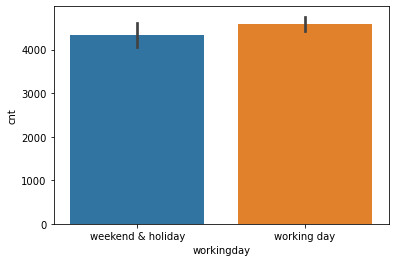

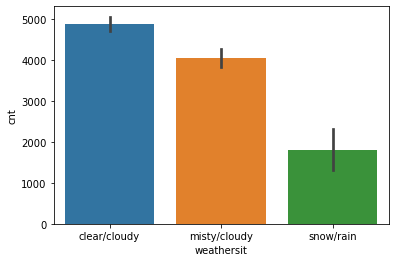

In [160]:
#Understanding categorical data with target variable
cat_features=["season","yr","mnth","holiday","weekday","workingday","weathersit"]
#Dictionary for x axis labels
cat_features_dict={"season":["spring","summer","fall","winter"],"yr":["2018","2019"],"mnth":["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"],"holiday":["Not Holiday","Holiday"]
,"weekday":["mon","tue","wed","thu","fri","sat","sun"],"workingday":["weekend & holiday","working day"],"weathersit":["clear/cloudy","misty/cloudy","snow/rain"]}
for feature in cat_features:
    ax=sns.barplot(data=data,y='cnt',x=feature)
    ax.set_xticklabels(cat_features_dict[feature])
    plt.show()

### Insights
-There are low customers sharing bikes during spring season<br>
-There are higher customers(nearly doubled) sharing bikes in 2019 as compared to 2018<br>
-People share bikes lesser in holidays as compared to non-holidays<br>
-People have taken more bikes in clear and cloudy weather as compared to other weather conditions<br>
-There is no significant effect of weekday or working day on the count of customers sharing the bikes<br><br>
`This helps us understand what might the important features to consider for linear regression based on the data`

In [161]:
#Describing numeric features in your dataset
numeric_features=["temp","atemp","hum","windspeed","cnt"]

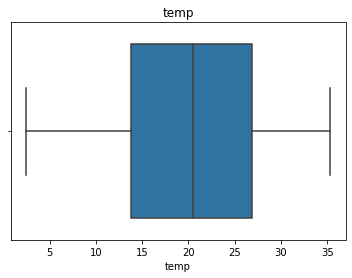

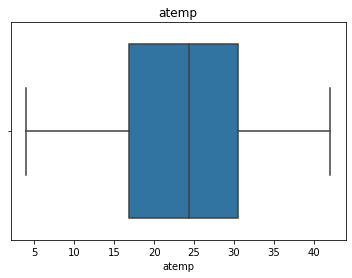

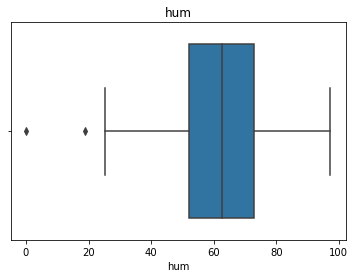

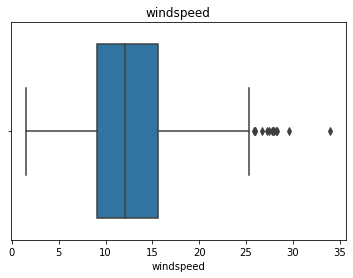

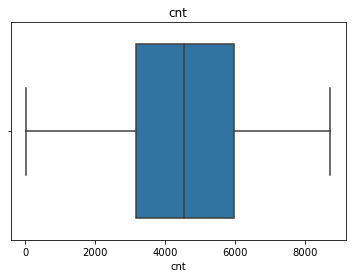

In [162]:
#Understanding the numeric data
#Checking box plot
for feature in numeric_features:
    sns.boxplot(data[feature])
    plt.title(feature)
    plt.show()

### Insights
- There are some outliers in input variables(humidity and windspeed)<br>
- There are no outliers in the target variable(cnt)<br>

`However we cannot remove outliers based on only input data, we have to check its effect on target variable and remove the outliers`

In [163]:
import plotly.express as px
for feature in numeric_features:
    if feature!="cnt":
        fig = px.scatter(data, x=feature, y="cnt")
        fig.show()


Outlier Detection - From the scatter plots, some points were out of trend, for fitting Linear regression model, its important to clean the data and remove extreme points(outliers)

In [164]:
#List of tuplies (feature value, target value)
outlier_temp=[(25.99043,1842),(27.88,1115),(18.04,22),(35.32835,4840)]
outlier_atemp=[(12.12,7148),(21.97,22),(31.7778,1115)]
outlier_hum=[(0,623),(18.7917,1635)]
Outlier_windspeed=[(1.500244,4985),(34.00002,1635),(29.58472,5382)]

In [165]:
data[numeric_features].describe()

,temp,atemp,hum,windspeed,cnt
count,730.000000,730.000000,730.000000,730.000000,730.000000
mean,20.319259,23.726322,62.765175,12.763620,4508.006849
std,7.506729,8.150308,14.237589,5.195841,1936.011647
min,2.424346,3.953480,0.000000,1.500244,22.000000
25%,13.811885,16.889713,52.000000,9.041650,3169.750000
50%,20.465826,24.368225,62.625000,12.125325,4548.500000
75%,26.880615,30.445775,72.989575,15.625589,5966.000000
max,35.328347,42.044800,97.250000,34.000021,8714.000000


In [166]:
# #We can find some outliers in windspeed and humidity,capping those variables to maximum bounds
# def remove_outliers(df,feature,tup):
#     for t in tup:
#         print(t)
#         # df=df[~((df[feature] == t[0]) & (df["cnt"] == t[1]))]
#         # print(len(df))
#         df.drop(df[(df[feature] == t[0]) & (df["cnt"] == t[1])].index, inplace = True)
#         print(len(df))
#     return df
# data=remove_outliers(data,"temp",outlier_temp)

In [180]:
# data["temp"]=data["temp"].astype("str")
data[data["temp"] == "25.99043"]

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt


In [ ]:
#Dummy encoding weathersit variable
#Combinations : 
#10 - Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
#01 - Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
#00 - Clear, Few clouds, Partly cloudy, Partly cloudy
# Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog -- Absent in data
weather_status=pd.get_dummies(data["weathersit"],drop_first=True)
weather_status.rename(columns={2:"misty",3:"light rain/snow"},inplace=True)
data=pd.concat([data,weather_status],axis=1)
# data.drop("weathersit",axis=1,inplace=True)

In [ ]:
#Dummy encoding seasons variable
#000-spring
#100-summer
#010-fall
#001-winter
seasons=pd.get_dummies(data["season"],drop_first=True)
seasons.rename(columns={2:"summer",3:"fall",4:"winter"},inplace=True)
data=pd.concat([data,seasons],axis=1)
# data.drop("season",axis=1,inplace=True)

In [ ]:
#Dataframe after encoding
data.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,misty,light rain/snow,summer,fall,winter
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,985,1,0,0,0,0
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,801,1,0,0,0,0
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,1349,0,0,0,0,0
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,1562,0,0,0,0,0
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,1600,0,0,0,0,0


In [147]:
from sklearn.model_selection import train_test_split

# We specify this so that the train and test data set always have the same rows, respectively
df_train, df_test = train_test_split(data, train_size = 0.7, test_size = 0.3, random_state = 100)

In [148]:
#Scaling Numeric features
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
#Training Set
# df_train[numeric_features] = scaler.fit_transform(df_train[numeric_features])
# #Test Set
# df_test[numeric_features] = scaler.transform(df_test[numeric_features])

<AxesSubplot:>

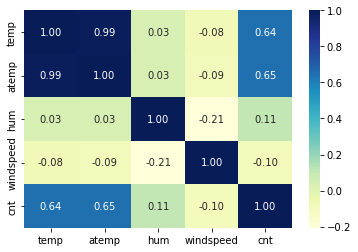

In [149]:
sns.heatmap(df_train[numeric_features].corr(),annot=True,cmap="YlGnBu",fmt=".2f")

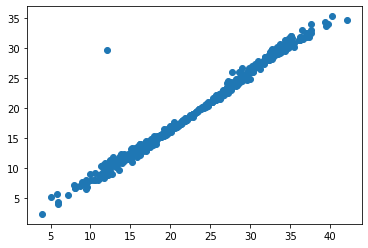

In [150]:
plt.scatter(x=df_train["atemp"],y=df_train["temp"])

In [151]:
#Dropping temp feature since its correlated with atemp very highly and follows a linear relation
#It will lead to multicolinearity in the model hence dropping it from data
#Actual temperature would be more relevant and has more correlation to target variable
df_train.drop("temp",axis=1,inplace=True)
df_test.drop("temp",axis=1,inplace=True)
data.drop("temp",axis=1,inplace=True)

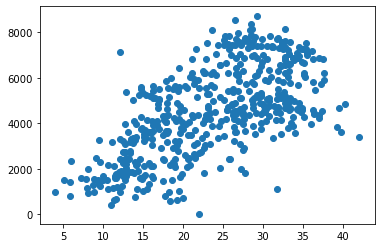

In [152]:
#Checking linearity of predictors with target variable
#actual temperature vs count
plt.scatter(x=df_train["atemp"],y=df_train["cnt"])
plt.show()

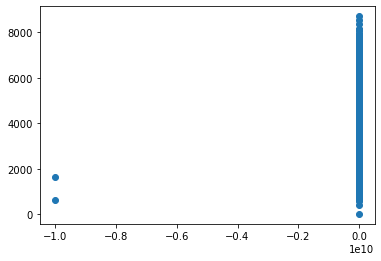

In [153]:
#Checking linearity of predictors with target variable
#humidity vs count
plt.scatter(x=df_train["hum"],y=df_train["cnt"])
plt.show()

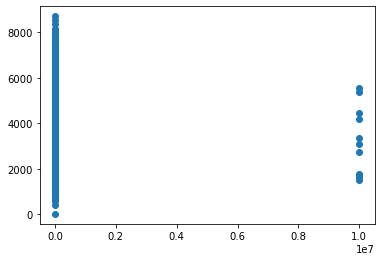

In [154]:
#Checking linearity of predictors with target variable
#windspeed vs count
plt.scatter(x=df_train["windspeed"],y=df_train["cnt"])
plt.show()

`All the numeric features show linearity with the target variable, it is good to use multi linear regression for this problem`


In [155]:
#Dividing into X & y sets
y_train = df_train.pop('cnt')
X_train = df_train

## Building Linear Model
### Following a bottoms up approach to keep adding on predictors, starting with atemp which seems the most correlated variable

#### **Feature 1** : `atemp`

In [156]:
import statsmodels.api as sm
feature_req=['atemp']
X_train_sm = sm.add_constant(X_train[feature_req])
lr = sm.OLS(y_train, X_train_sm).fit()

In [171]:
#Summary
lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.773
Model:                            OLS   Adj. R-squared:                  0.771
Method:                 Least Squares   F-statistic:                     343.1
Date:                Fri, 29 Apr 2022   Prob (F-statistic):          1.18e-159
Time:                        22:46:13   Log-Likelihood:                -4209.2
No. Observations:                 510   AIC:                             8430.
Df Residuals:                     504   BIC:                             8456.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              82.1987    146.863      0.560      0.576    -206.341     370.738
atemp             127.0212      5.352     23.732      0.000     116.506     137.537
yr               2047.6997     83.459     24.535      0.000    1883.729    2211.670
mnth               99.7014     12.392      8.045      0.000      75.354     124.049
misty            -594.3505     88.291     -6.732      0.000    -767.815    -420.886
light rain/snow -2344.4658    248.764     -9.424      0.000   -2833.208   -1855.723
==============================================================================
Omnibus:                       55.459   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              104.497
Skew:                          -0.654   Prob(JB):                     2.04e-23
Kurtosis:                       4.791   Cond. No.                         155.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

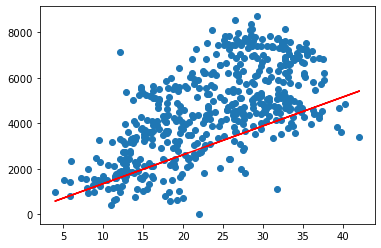

In [172]:
# Visualizing fitting potential of our model with actual data
x_train_atemp=X_train_sm.loc[:, "atemp"]
y_pred_atemp=lr.params["const"] + lr.params["atemp"]*X_train_sm.iloc[:, 1]
plt.scatter(x_train_atemp, y_train)
plt.plot(x_train_atemp,y_pred_atemp, 'r')
plt.show()

## Rsquared_1= `0.418`

#### **Feature 2** : `yr`
Since we can see the demand of bikes going up in 2019 as compared to 2018

In [173]:
X_train.columns

Index(['yr', 'mnth', 'holiday', 'weekday', 'workingday', 'atemp', 'hum',
       'windspeed', 'misty', 'light rain/snow', 'summer', 'fall', 'winter'],
      dtype='object')

In [174]:
feature_req.append('yr')
X_train_sm = sm.add_constant(X_train[feature_req])
lr = sm.OLS(y_train, X_train_sm).fit()

In [175]:
#Summary
lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.773
Model:                            OLS   Adj. R-squared:                  0.771
Method:                 Least Squares   F-statistic:                     343.1
Date:                Fri, 29 Apr 2022   Prob (F-statistic):          1.18e-159
Time:                        22:46:19   Log-Likelihood:                -4209.2
No. Observations:                 510   AIC:                             8430.
Df Residuals:                     504   BIC:                             8456.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              82.1987    146.863      0.560      0.576    -206.341     370.738
atemp             127.0212      5.352     23.732      0.000     116.506     137.537
yr               1023.8498     41.730     24.535      0.000     941.865    1105.835
mnth               99.7014     12.392      8.045      0.000      75.354     124.049
misty            -594.3505     88.291     -6.732      0.000    -767.815    -420.886
light rain/snow -2344.4658    248.764     -9.424      0.000   -2833.208   -1855.723
yr               1023.8498     41.730     24.535      0.000     941.865    1105.835
==============================================================================
Omnibus:                       55.459   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              104.497
Skew:                          -0.654   Prob(JB):                     2.04e-23
Kurtosis:                       4.791   Cond. No.                     3.22e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.25e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

## Rsquared_2 = `0.696`

#### **Feature 3** : `mnth`
Its logical that the month of the year can affect the demand, holiday seasons etc


In [162]:
X_train.columns

Index(['yr', 'mnth', 'holiday', 'weekday', 'workingday', 'atemp', 'hum',
       'windspeed', 'misty', 'light rain/snow', 'summer', 'fall', 'winter'],
      dtype='object')

In [163]:
feature_req.append('mnth')
X_train_sm = sm.add_constant(X_train[feature_req])
lr = sm.OLS(y_train, X_train_sm).fit()

In [164]:
#Summary
lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.719
Model:                            OLS   Adj. R-squared:                  0.717
Method:                 Least Squares   F-statistic:                     431.7
Date:                Fri, 29 Apr 2022   Prob (F-statistic):          4.71e-139
Time:                        22:45:58   Log-Likelihood:                -4263.5
No. Observations:                 510   AIC:                             8535.
Df Residuals:                     506   BIC:                             8552.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -285.0505    155.823     -1.829      0.068    -591.191      21.090
atemp        133.0427      5.906     22.527      0.000     121.440     144.646
yr          2093.2375     92.506     22.628      0.000    1911.495    2274.980
mnth          88.9755     13.701      6.494      0.000      62.057     115.894
==============================================================================
Omnibus:                       78.343   Durbin-Watson:                   2.020
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              165.979
Skew:                          -0.840   Prob(JB):                     9.08e-37
Kurtosis:                       5.233   Cond. No.                         88.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Rsquared_3 = `0.719`

#### **Feature 4** : `misty,light rain/snow`
Weather can affect the demand for the bikes


In [165]:
X_train.columns

Index(['yr', 'mnth', 'holiday', 'weekday', 'workingday', 'atemp', 'hum',
       'windspeed', 'misty', 'light rain/snow', 'summer', 'fall', 'winter'],
      dtype='object')

In [166]:
feature_req.append('misty')
feature_req.append('light rain/snow')
X_train_sm = sm.add_constant(X_train[feature_req])
lr = sm.OLS(y_train, X_train_sm).fit()

In [167]:
#Summary
lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.773
Model:                            OLS   Adj. R-squared:                  0.771
Method:                 Least Squares   F-statistic:                     343.1
Date:                Fri, 29 Apr 2022   Prob (F-statistic):          1.18e-159
Time:                        22:45:58   Log-Likelihood:                -4209.2
No. Observations:                 510   AIC:                             8430.
Df Residuals:                     504   BIC:                             8456.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              82.1987    146.863      0.560      0.576    -206.341     370.738
atemp             127.0212      5.352     23.732      0.000     116.506     137.537
yr               2047.6997     83.459     24.535      0.000    1883.729    2211.670
mnth               99.7014     12.392      8.045      0.000      75.354     124.049
misty            -594.3505     88.291     -6.732      0.000    -767.815    -420.886
light rain/snow -2344.4658    248.764     -9.424      0.000   -2833.208   -1855.723
==============================================================================
Omnibus:                       55.459   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              104.497
Skew:                          -0.654   Prob(JB):                     2.04e-23
Kurtosis:                       4.791   Cond. No.                         155.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Rsquared_4 = `0.773`

In [168]:
X_train.columns

Index(['yr', 'mnth', 'holiday', 'weekday', 'workingday', 'atemp', 'hum',
       'windspeed', 'misty', 'light rain/snow', 'summer', 'fall', 'winter'],
      dtype='object')

In [169]:
# feature_req=['atemp', 'yr', 'workingday','weekday','summer', 'fall', 'winter']
X_train_sm = sm.add_constant(X_train[feature_req])
lr = sm.OLS(y_train, X_train_sm).fit()
#Summary
lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.773
Model:                            OLS   Adj. R-squared:                  0.771
Method:                 Least Squares   F-statistic:                     343.1
Date:                Fri, 29 Apr 2022   Prob (F-statistic):          1.18e-159
Time:                        22:45:58   Log-Likelihood:                -4209.2
No. Observations:                 510   AIC:                             8430.
Df Residuals:                     504   BIC:                             8456.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              82.1987    146.863      0.560      0.576    -206.341     370.738
atemp             127.0212      5.352     23.732      0.000     116.506     137.537
yr               2047.6997     83.459     24.535      0.000    1883.729    2211.670
mnth               99.7014     12.392      8.045      0.000      75.354     124.049
misty            -594.3505     88.291     -6.732      0.000    -767.815    -420.886
light rain/snow -2344.4658    248.764     -9.424      0.000   -2833.208   -1855.723
==============================================================================
Omnibus:                       55.459   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              104.497
Skew:                          -0.654   Prob(JB):                     2.04e-23
Kurtosis:                       4.791   Cond. No.                         155.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [170]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
features=X_train[feature_req]
vif['Features'] = features.columns
vif['VIF'] = [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
print(vif)

          Features   VIF
0            atemp  5.16
2             mnth  4.36
1               yr  1.96
3            misty  1.43
4  light rain/snow  1.05


In [180]:
ypred=lr.predict(X_train_sm)
res=ypred-y_train

<AxesSubplot:ylabel='Density'>

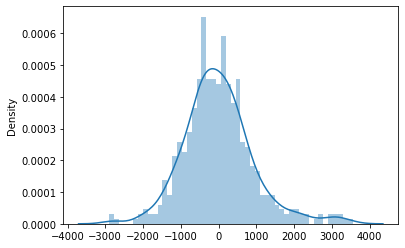

In [181]:
sns.distplot(res,bins=50)

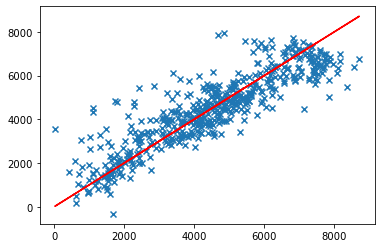

In [184]:
plt.scatter(y_train, ypred,marker='x')
plt.plot(y_train,y_train, 'r')
plt.show()

In [192]:
from scipy.stats import shapiro
import random
from numpy.random import randn
data1 = randn(1000)+pow(2,randn(1000))
stat, p = shapiro(data1)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Sample looks Gaussian (fail to reject H0)')
else:
	print('Sample does not look Gaussian (reject H0)')

Statistics=0.948, p=0.000
Sample does not look Gaussian (reject H0)


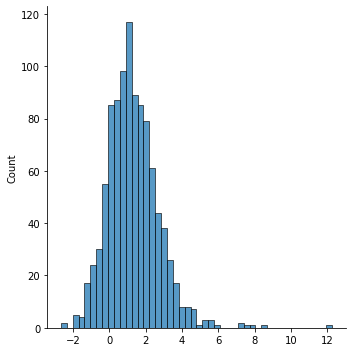

In [193]:
sns.displot(data1)

In [187]:
data

-1.7344058724925462

In [190]:
from numpy.random import seed
from numpy.random import randn
from scipy.stats import shapiro
# seed the random number generator
seed(1)
# generate univariate observations
data = 5 * randn(100) + 50
# normality test
stat, p = shapiro(data)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Sample looks Gaussian (fail to reject H0)')
else:
	print('Sample does not look Gaussian (reject H0)')

Statistics=0.992, p=0.822
Sample looks Gaussian (fail to reject H0)
